In [1]:
import cv2
import numpy as np

In [2]:
img = cv2.imread("./data/Dozen_0.bmp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
import matplotlib.pyplot

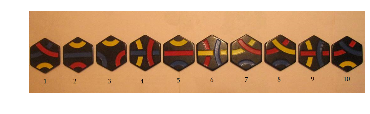

In [4]:
%matplotlib inline
matplotlib.pyplot.imshow(img)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()

In [5]:
gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

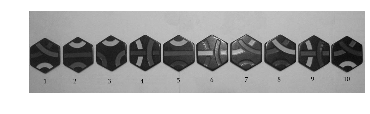

In [6]:
%matplotlib inline
matplotlib.pyplot.imshow(gs, "gray")
matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()

In [7]:
th = cv2.adaptiveThreshold(gs, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 63, 8)
th = ~th

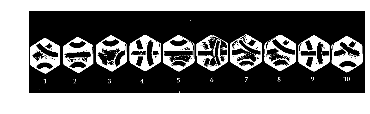

In [8]:
%matplotlib inline
matplotlib.pyplot.imshow(th, "gray")
matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()

In [9]:
def get_threshold(gs):
    th = cv2.adaptiveThreshold(gs, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 63, 8)
    th = ~th
    return th

def get_contours(gs, threshold=True):
    if threshold:
        th = cv2.adaptiveThreshold(gs, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 63, 8)
        th = ~th
    else:
        th = gs.copy()
    contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return filter(lambda c: cv2.contourArea(c) > 3000.0, contours)

In [10]:
contours2 = get_contours(gs)

In [11]:
def get_inside(img, contours):
    img2 = np.zeros(img.shape[:2], 'uint8')
    cv2.drawContours(img2, contours, -1, 255, -1)
    return img2

In [12]:
img2 = get_inside(img, contours2)

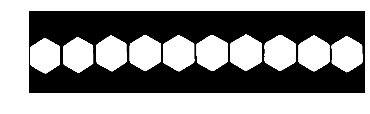

In [13]:
%matplotlib inline
matplotlib.pyplot.imshow(img2, 'gray')
matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()

In [14]:
def erode_contours(img, contours):
    img2 = np.zeros(img.shape[:2], 'uint8')
    cv2.drawContours(img2, contours, -1, 255, -1)
    sz = cv2.arcLength(contours[0], True) / 20
    kernel = np.ones((sz, sz),np.uint8)
    erosion = cv2.erode(img2, kernel)
    contours3, hierarchy3 = cv2.findContours(erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours3

In [15]:
contours3 = erode_contours(img, contours2)

In [16]:
def draw_countors(img, contours):
    img3 = img.copy()
    cv2.drawContours(img3, contours, -1, (0, 255, 0), 3)
    return img3

In [17]:
img3 = draw_countors(img, contours3)

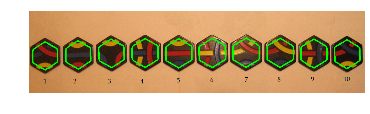

In [18]:
%matplotlib inline
matplotlib.pyplot.imshow(img3)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()

In [19]:
def get_ry(img, img2, r_thresh=-4, y_thresh=-4):
    img_y = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(32, 32))
    channels = cv2.split(img_y)
    channels[0] = clahe.apply(channels[0])
    img_y = cv2.merge(channels, 3)
    img_y = cv2.cvtColor(img_y, cv2.COLOR_YUV2RGB )

    img_y = cv2.medianBlur(img_y, 13)

    channels = cv2.split(img_y)

    source = np.array(map(lambda x, y: map(lambda u, v: u - min(u, v), x, y), channels[0], channels[1]), dtype='uint8')
    th_r = cv2.adaptiveThreshold(source, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 63, r_thresh)
    th_r = cv2.bitwise_and(th_r, img2)

    source = np.array(map(lambda x, y, z: map(lambda u, v, w: v - min(u / 2 + w / 2, v), x, y, z),
                          channels[0], channels[1], channels[2]), dtype='uint8')
    th_y = cv2.adaptiveThreshold(source, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 63, y_thresh)
    th_y = cv2.bitwise_and(th_y, img2)

    th_y = cv2.morphologyEx(th_y, cv2.MORPH_OPEN, np.ones((5, 5),np.uint8))
    th_y = cv2.morphologyEx(th_y, cv2.MORPH_CLOSE, np.ones((5, 5),np.uint8))
    th_y = cv2.morphologyEx(th_y, cv2.MORPH_DILATE, np.ones((1, 1),np.uint8))
    th_r = cv2.morphologyEx(th_r, cv2.MORPH_OPEN, np.ones((5, 5),np.uint8))
    th_r = cv2.morphologyEx(th_r, cv2.MORPH_CLOSE, np.ones((5, 5),np.uint8))
    th_r = cv2.morphologyEx(th_r, cv2.MORPH_DILATE, np.ones((1, 1),np.uint8))
    
    contours, hierarchy = cv2.findContours(th_y.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = filter(lambda c: cv2.contourArea(c) < 100.0, contours)
    inside = get_inside(img, contours)
    
    for i in range(len(img)):
        for j in range(len(img[0])):
            if inside[i][j]:
                th_y[i][j] = 0
                
    contours, hierarchy = cv2.findContours(th_r.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = filter(lambda c: cv2.contourArea(c) < 100.0, contours)
    inside = get_inside(img, contours)
    
    for i in range(len(img)):
        for j in range(len(img[0])):
            if inside[i][j]:
                th_r[i][j] = 0
    
    return th_r, th_y

In [20]:
th_r, th_y = get_ry(img, img2)

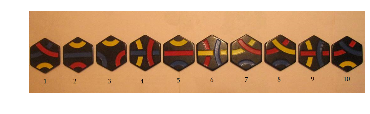

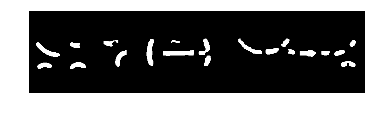

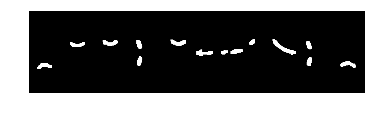

In [21]:
%matplotlib inline
matplotlib.pyplot.imshow(img)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(th_r, 'gray')
matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(th_y, 'gray')
matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()

In [22]:
def count_labels(l, verbose=False):
    sz = len(l)
    start = 0
    old = -1
    labels = []
    counts12 = []
    counts = []
    for i in range(sz):
        if l[i] != 0:
            start = i
            break
    i = start
    for j in range(sz):
        if l[i] == 0:
            start = i
            break
        i =(i + 1) % sz
    i = start
    l2 = map(lambda x: x if x != 2 else 1, l)
    for j in range(sz):
        if l2[i] == old:
            counts[-1] += 1
            counts12[-1][l[i] - 1] += 1
        else:
            old = l2[i]
            labels.append(l2[i])
            counts12.append([0, 0])
            counts12[-1][l[i] - 1] += 1
            counts.append(1)
        i = (i + 1) % sz
        
    for i in range(len(labels)):
        if (labels[i] == 1) and (3 * counts12[i][1] / 2 > counts12[i][0]):
            labels[i] = 2
            
    if verbose:
        print labels, counts
    
    cnt_sz = len(labels)
    labels_out = cnt_sz * [0]
    
    counts_1 = list(counts)
    for i in filter(lambda j: labels[j] != 0, range(cnt_sz)):
        counts_1[i] = -1
    pos1 = np.argmax(counts_1)
    max1 = np.max(counts_1)
    labels_out[pos1] = 3
    counts_1[pos1] = -1
    pos2 = np.argmax(counts_1)
    max2 = np.max(counts_1)
    if max1 < 3 * max2 / 2:
        labels_out[pos2] = 3
    else:
        labels_out[pos1] = 4
    
    counts_1 = list(counts)
    for i in filter(lambda j: labels[j] != 1, range(cnt_sz)):
        counts_1[i] = -1
    pos1 = np.argmax(counts_1)
    max1 = np.max(counts_1)
    labels_out[pos1] = 1
    counts_1[pos1] = -1
    pos2 = np.argmax(counts_1)
    max2 = np.max(counts_1)
    if 4 < max2:
        labels_out[pos2] = 1
    else:
        labels_out[pos1] = 5
    
    counts_1 = list(counts)
    for i in filter(lambda j: labels[j] != 2, range(cnt_sz)):
        counts_1[i] = -1
    pos1 = np.argmax(counts_1)
    max1 = np.max(counts_1)
    labels_out[pos1] = 2
    counts_1[pos1] = -1
    pos2 = np.argmax(counts_1)
    max2 = np.max(counts_1)
    if 4 < max2:
        labels_out[pos2] = 2
    else:
        labels_out[pos1] = 6
    
    labels = []
    for i in labels_out:
        if i == 4:
            labels.append(3)
            labels.append(3)
        elif i == 5:
            labels.append(1)
            labels.append(1)
        elif i == 6:
            labels.append(2)
            labels.append(2)
        else:
            labels.append(i)
    return filter(lambda x: x != 0, labels)

In [23]:
def contour_label(cnt, th_y, th_r, verbose=False):
    pixels = map(lambda e: (th_y[e[0][1], e[0][0]], th_r[e[0][1], e[0][0]]), cnt)
    color_labels = map(lambda p: 2 if p[0] else 1 if p[1] else 0, pixels)
    if verbose:
        print color_labels
    return count_labels(color_labels, verbose)

### 1. Определить количество фишек на изображении. Входом является файл типа Group_*.bmp.

In [24]:
def item_count(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    contours = get_contours(gs)
    img3 = draw_countors(img, contours)
    matplotlib.pyplot.imshow(img3)
    matplotlib.pyplot.axis('off')
    matplotlib.pyplot.show() 
    return len(contours)

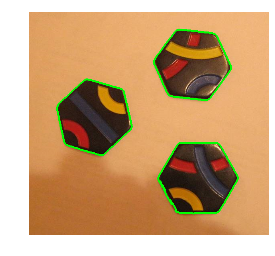

3 items


In [25]:
%matplotlib inline
print item_count("./data/Group_1.bmp"), 'items'

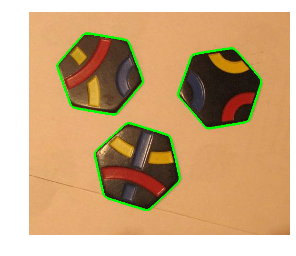

3 items


In [26]:
%matplotlib inline
print item_count("./data/Group_2.bmp"), 'items'

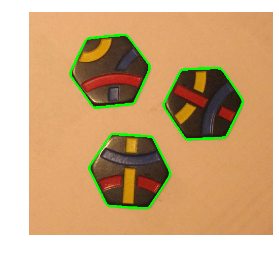

3 items


In [27]:
%matplotlib inline
print item_count("./data/Group_3.bmp"), 'items'

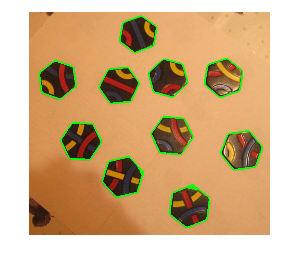

10 items


In [28]:
%matplotlib inline
print item_count("./data/Group_4.bmp"), 'items'

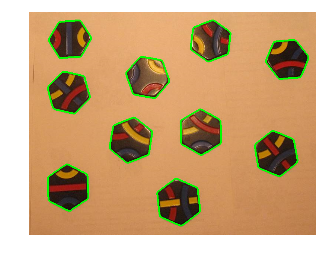

10 items


In [29]:
%matplotlib inline
print item_count("./data/Group_5.bmp"), 'items'

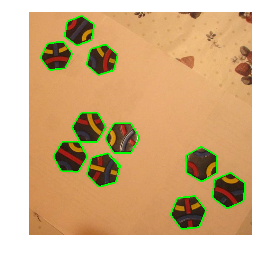

10 items


In [30]:
%matplotlib inline
print item_count("./data/Group_6.bmp"), 'items'

### 2. Определить тип и цвет линий на фишке – короткая дуга большой кривизны, длинная дуга малой кривизны, прямолинейный сегмент. Вход – файл типа Single_*.bmp.

In [31]:
def segment_length(cl, idx):
    l = []
    for i in range(len(cl)):
        if cl[i] == idx:
            l.append(i)
    a, b = l[0], l[1]
    return min(abs(a - b), abs(len(cl) + a - b), abs(len(cl) + b - a))

def semgent_type(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    contours = get_contours(gs)
    img3 = draw_countors(img, contours)
    matplotlib.pyplot.imshow(img3)
    matplotlib.pyplot.axis('off')
    matplotlib.pyplot.show() 
    img2 = get_inside(img, contours)
    contours3 = erode_contours(img, contours)
    th_r, th_y = get_ry(img, img2)
    cl = contour_label(contours3[0], th_y, th_r)
    return segment_length(cl, 1), segment_length(cl, 2), segment_length(cl, 3)
    

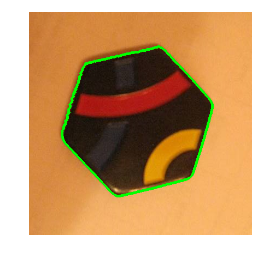

Red length = 2
Yellow length = 1
Blue length = 2


In [32]:
r_len, y_len, b_len = semgent_type("./data/Single_0.bmp")
print "Red length =", r_len 
print "Yellow length =", y_len
print "Blue length =", b_len

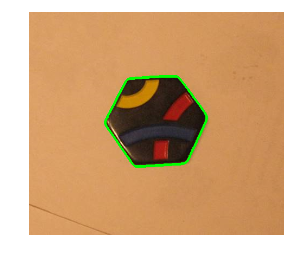

Red length = 2
Yellow length = 1
Blue length = 2


In [33]:
r_len, y_len, b_len = semgent_type("./data/Single_1.bmp")
print "Red length =", r_len 
print "Yellow length =", y_len
print "Blue length =", b_len

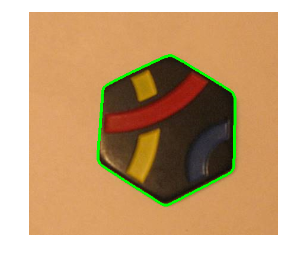

Red length = 2
Yellow length = 2
Blue length = 1


In [34]:
r_len, y_len, b_len = semgent_type("./data/Single_2.bmp")
print "Red length =", r_len 
print "Yellow length =", y_len
print "Blue length =", b_len

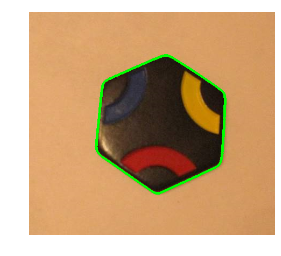

Red length = 1
Yellow length = 1
Blue length = 1


In [35]:
r_len, y_len, b_len = semgent_type("./data/Single_3.bmp")
print "Red length =", r_len 
print "Yellow length =", y_len
print "Blue length =", b_len

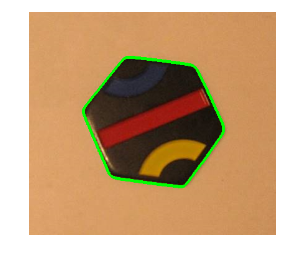

Red length = 3
Yellow length = 1
Blue length = 1


In [36]:
r_len, y_len, b_len = semgent_type("./data/Single_4.bmp")
print "Red length =", r_len 
print "Yellow length =", y_len
print "Blue length =", b_len

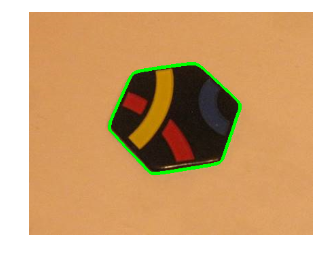

Red length = 2
Yellow length = 2
Blue length = 1


In [37]:
r_len, y_len, b_len = semgent_type("./data/Single_5.bmp")
print "Red length =", r_len 
print "Yellow length =", y_len
print "Blue length =", b_len

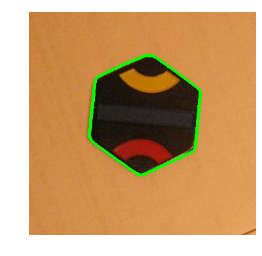

Red length = 1
Yellow length = 1
Blue length = 3


In [38]:
r_len, y_len, b_len = semgent_type("./data/Single_6.bmp")
print "Red length =", r_len 
print "Yellow length =", y_len
print "Blue length =", b_len

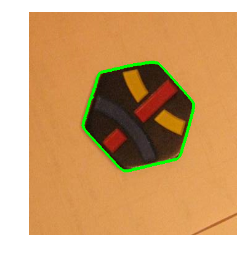

Red length = 3
Yellow length = 2
Blue length = 2


In [39]:
r_len, y_len, b_len = semgent_type("./data/Single_7.bmp")
print "Red length =", r_len 
print "Yellow length =", y_len
print "Blue length =", b_len

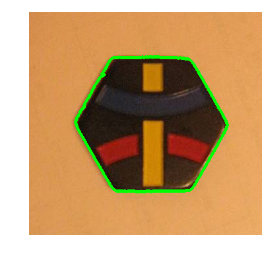

Red length = 2
Yellow length = 3
Blue length = 2


In [40]:
r_len, y_len, b_len = semgent_type("./data/Single_8.bmp")
print "Red length =", r_len 
print "Yellow length =", y_len
print "Blue length =", b_len

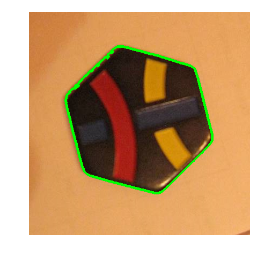

Red length = 2
Yellow length = 2
Blue length = 3


In [41]:
r_len, y_len, b_len = semgent_type("./data/Single_9.bmp")
print "Red length =", r_len 
print "Yellow length =", y_len
print "Blue length =", b_len

### 3. Определить номер фишки. Вход – файл типа Single_*.bmp.

In [42]:
def draw_text(img, s, coord):
    cv2.putText(img, s, (coord[0], coord[1]), 
        cv2.FONT_HERSHEY_COMPLEX_SMALL, 4.0, (255, 255, 255), 5, cv2.CV_AA);
    
def contour_cmp(a, b):
    if a[0][0][0] < b[0][0][0]:
        return -1
    if a[0][0][0] > b[0][0][0]:
        return 1
    return 0

def cl_to_str(cl):
    s = ""
    for i in cl:
        s += str(i)
    return s

def get_database(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    contours = get_contours(gs)
    img3 = draw_countors(img, contours)
    img2 = get_inside(img, contours)
    contours3 = sorted(erode_contours(img, contours), cmp=contour_cmp)
    for i in range(len(contours3)):
        draw_text(img3, str(i + 1), contours3[i][0][0])
    th_r, th_y = get_ry(img, img2)
    return map(lambda x: (cl_to_str(contour_label(contours3[x], th_y, th_r)), x + 1), range(len(contours3)))

In [43]:
db = get_database("./data/Dozen_0.bmp")

In [44]:
print db

[('322131', 1), ('311322', 2), ('331122', 3), ('321312', 4), ('133122', 5), ('213231', 6), ('233121', 7), ('133212', 8), ('123132', 9), ('223131', 10)]


In [45]:
def item_number(filename, db, verbose=False):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    contours = get_contours(gs)
    img3 = draw_countors(img, contours) 
    img2 = get_inside(img, contours)
    contours3 = erode_contours(img, contours)
    th_r, th_y = get_ry(img, img2)
    if verbose:
        matplotlib.pyplot.imshow(th_r, 'gray')
        matplotlib.pyplot.axis('off')
        matplotlib.pyplot.show()
        matplotlib.pyplot.imshow(th_y, 'gray')
        matplotlib.pyplot.axis('off')
        matplotlib.pyplot.show()
    for i in range(len(contours3)):
        cl = contour_label(contours3[i], th_y, th_r, verbose=verbose)
        p = cl_to_str(cl)
        for j in db:
            s = j[0] + j[0]
            if s.find(p) != -1:
                item_num = j[1]
                break
        if verbose:
            print(item_num)
        draw_text(img3, str(item_num), contours3[i][0][0])
    matplotlib.pyplot.imshow(img3)
    matplotlib.pyplot.axis('off')
    matplotlib.pyplot.show() 

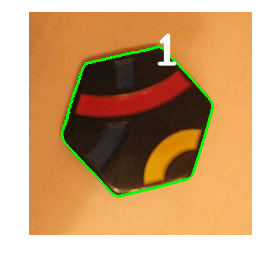

In [46]:
item_number("./data/Single_0.bmp", db)

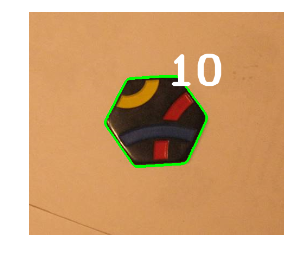

In [47]:
item_number("./data/Single_1.bmp", db)

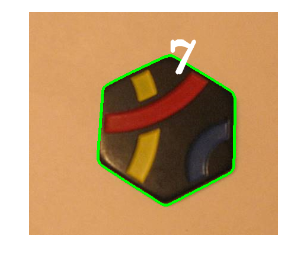

In [48]:
item_number("./data/Single_2.bmp", db)

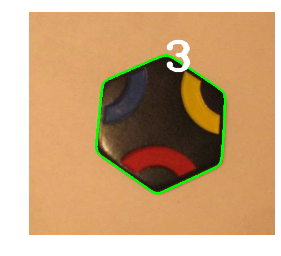

In [49]:
item_number("./data/Single_3.bmp", db)

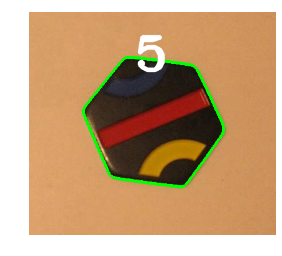

In [50]:
item_number("./data/Single_4.bmp", db)

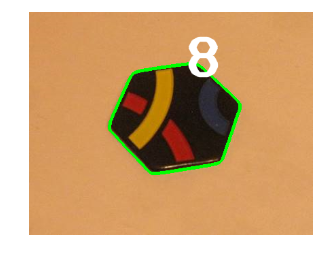

In [51]:
item_number("./data/Single_5.bmp", db)

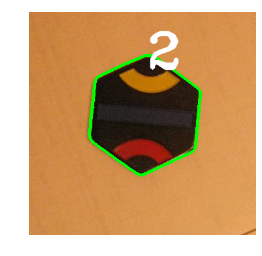

In [52]:
item_number("./data/Single_6.bmp", db)

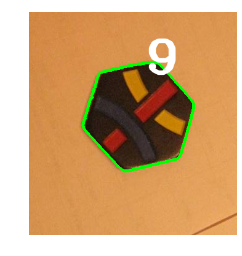

In [53]:
item_number("./data/Single_7.bmp", db)

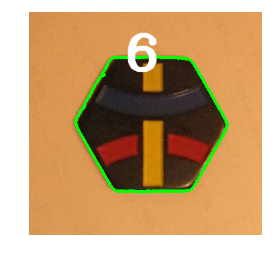

In [54]:
item_number("./data/Single_8.bmp", db)

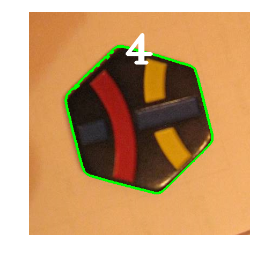

In [55]:
item_number("./data/Single_9.bmp", db)

### 4. Определить расположение и номера всех фишек в кадре. Вход – файл типа Group_*.bmp.

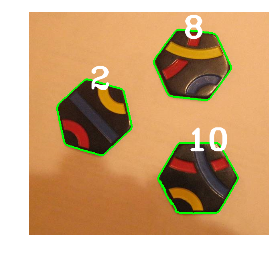

In [56]:
item_number("./data/Group_1.bmp", db)

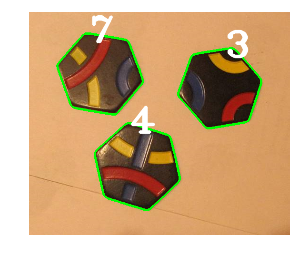

In [57]:
item_number("./data/Group_2.bmp", db)

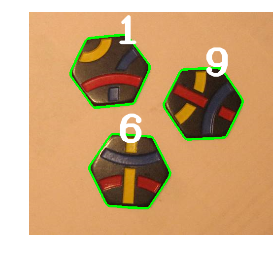

In [58]:
item_number("./data/Group_3.bmp", db)

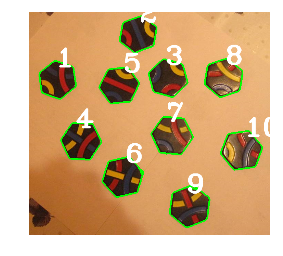

In [59]:
item_number("./data/Group_4.bmp", db)

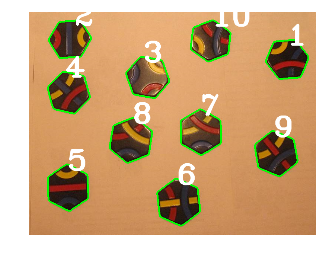

In [60]:
item_number("./data/Group_5.bmp", db)

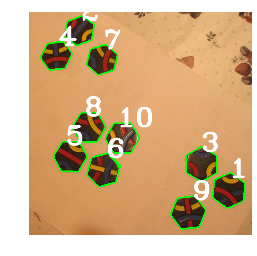

In [61]:
item_number("./data/Group_6.bmp", db)

### 5. Определить последовательность обхода фишек в мозаике вдоль замкнутого маршрута. Вход – файл типа Path_*.bmp.

In [62]:
img = cv2.imread("./data/Path_5.bmp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #оттенки серого

In [63]:
contours2 = get_contours(gs) #контур

In [64]:
img2 = get_inside(img, contours2) # бинаризация

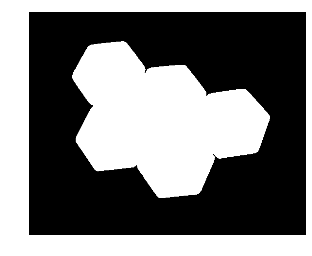

In [65]:
%matplotlib inline
matplotlib.pyplot.imshow(img2, 'gray')
matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()

In [66]:
selem = np.ones((9, 9))
dilated = cv2.morphologyEx(img2, cv2.MORPH_CLOSE, selem)

In [67]:
def show_binar(img):
    %matplotlib inline
    matplotlib.pyplot.imshow(img, 'gray')
    matplotlib.pyplot.axis('off')
    matplotlib.pyplot.show()

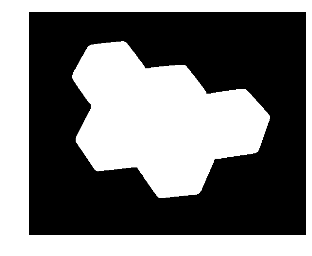

In [68]:
show_binar(dilated)

In [69]:
def show_col(img):
    %matplotlib inline
    matplotlib.pyplot.imshow(img)
    matplotlib.pyplot.axis('off')
    matplotlib.pyplot.show()

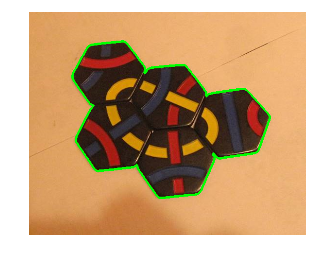

In [70]:
contours2 = get_contours(img2, False)
img3 = draw_countors(img, contours2)
show_col(img3)

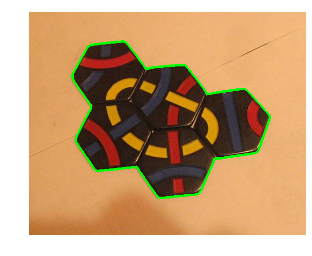

In [71]:
contours2 = get_contours(dilated, False)
img3 = draw_countors(img, contours2)
show_col(img3)

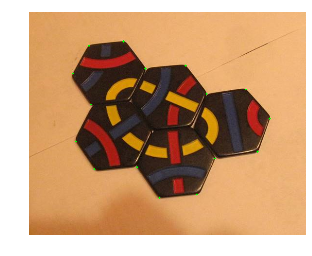

In [72]:
ap = cv2.approxPolyDP(contours2[0], cv2.arcLength(contours2[0], True) / 100, True)
img4 = draw_countors(img, ap)
show_col(img4)

In [73]:
cv2.arcLength(contours2[0], True)

1311.425529718399

In [74]:
ap2 = map(lambda x: x[0], ap)

In [75]:
def get_angle(a, b):
    an = a / np.linalg.norm(a)
    bn = b / np.linalg.norm(b)
    return np.dot(an, bn)

In [76]:
result = []
for i in range(len(ap2)):
    p1 = ap2[i]
    p2 = ap2[(i + 1) % len(ap2)]
    p3 = ap2[(i + 2) % len(ap2)]
    v1 = p1 - p2
    v2 = p3 - p2
    result.append(get_angle(v1, v2))

In [77]:
def rotation_matrix(angle):
    return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

def add_points(p1, p2, new_points):
    v = p2 - p1
    m1 = rotation_matrix(+ 60.0 / 180.0 * np.pi)
    m2 = rotation_matrix(- 60.0 / 180.0 * np.pi)
    new_points.append(p2 + np.dot(m1, v))
    new_points.append(p2 + np.dot(m2, v))
    
def points_to_contour(points):
    return np.array(map(lambda x: [x], points), 'int32')

def hagrid(points, polygon):
    new_points = []
    slen = 0.0
    for i in range(len(points)):
        p1 = points[i]
        p2 = points[(i + 1) % len(points)]
        new_points.append(p1)
        new_points.append(p2)
        slen += np.linalg.norm(p2 - p1)
        add_points(p1, p2, new_points)
        add_points(p2, p1, new_points)
    slen /= len(points)
    result = []
    for i in points:
        result.append(i)
    for i in new_points:
        ok = False
        for j in range(len(points)):
            if np.linalg.norm(i - points[j]) < slen * 0.5:
                ok = True
                break
        if ok:
            continue
        ok = False
        for j in range(len(result)):
            if np.linalg.norm(i - result[j]) < slen * 0.5:
                ok = True
                result[j] = (0.5 * result[j] + 0.5 * i)
                break
        if not ok:
            result.append(i)
    return filter(lambda x: cv2.pointPolygonTest(polygon, (x[0], x[1]), True) > - slen * 0.5, result)

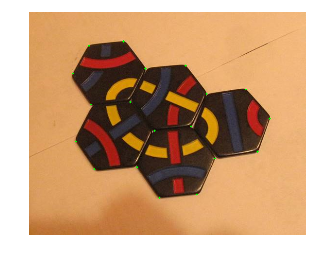

In [78]:
ap3 = hagrid(ap2, points_to_contour(ap2))
ap3 = hagrid(ap3, points_to_contour(ap2))
img5 = draw_countors(img, points_to_contour(ap3))
show_col(img5)

In [79]:
def build_graph(ap3):
    g = []
    for i in range(len(ap3)):
        vl = []
        min_dist = -1
        for j in range(len(ap3)):
            if i == j:
                continue
            cur_dist = np.linalg.norm(ap3[i] - ap3[j])
            if (min_dist == -1) or (cur_dist < min_dist):
                min_dist = cur_dist
        for j in range(len(ap3)):
            if i == j:
                continue
            cur_dist = np.linalg.norm(ap3[i] - ap3[j])
            if abs(cur_dist - min_dist) < min_dist * 0.5:
                vl.append(j)
        g.append(vl)
    for i in range(len(g)):
        for j in g[i]:
            found = False
            for k in g[j]:
                if k == i:
                    found = True
                    break
            if not found:
                g[j].append(i)
    return g

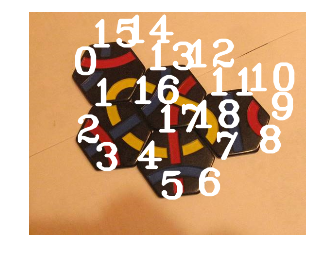

In [80]:
img6 = img.copy()
for i in range(len(ap3)):
    draw_text(img6, str(i), (int(ap3[i][0]), int(ap3[i][1])))
show_col(img6)

In [81]:
g = build_graph(ap3)

In [82]:
g

[[1, 15],
 [0, 2, 16],
 [1, 3],
 [2, 4],
 [3, 5, 17],
 [4, 6],
 [5, 7],
 [6, 8, 18],
 [7, 9],
 [8, 10],
 [9, 11],
 [10, 12, 18],
 [11, 13],
 [12, 14, 16],
 [13, 15],
 [0, 14],
 [1, 13, 17],
 [4, 16, 18],
 [7, 11, 17]]

In [83]:
def dfs(g, v, p, st, vp, path=[], depth=0):
    if depth == 6:
        if v == st:
            vp.append(path)
        return
    for u in g[v]:
        if p != u:
            dfs(g, u, v, st, vp, path + [u], depth + 1)
                      
def clockwise(ap, path):
    p1 = ap[path[0]]
    p2 = ap[path[1]]
    p3 = ap[path[2]]
    v1 = p2 - p1
    v2 = p3 - p2
    return np.cross(v1, v2)

In [84]:
def get_paths(g, ap3, v):
    vp = []
    dfs(g, v, -1, v, vp)
    return filter(lambda x: clockwise(ap3, x) < 0, vp)

In [85]:
def path_similiar(p1, p2):
    st = 0
    for i in range(len(p2)):
        if p2[i] == p1[0]:
            st = i
            break
    for i in range(len(p1)):
        if p1[i] != p2[st]:
            return False
        st = (st + 1) % len(p2)
    return True

def add_path(paths, p):
    for i in range(len(p)):
        for j in range(len(p)):
            if i == j:
                continue
            if p[i] == p[j]:
                return
    ok = False
    for cur in paths:
        if path_similiar(cur, p):
            ok = True
            break
    if not ok:
        paths.append(p)

In [86]:
def get_all_paths(g, ap3):
    paths = []
    for i in range(len(g)):
        p = get_paths(g, ap3, i)
        for j in p:
            add_path(paths, j)
    return paths

In [87]:
paths = get_all_paths(g, ap3)

In [88]:
def contour_center(cnt):
    moments = cv2.moments(cnt)
    return int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00'])

def erode_item_contours(img, item_contours):
    result = []
    for i in range(len(item_contours)):
        img2 = np.zeros(img.shape[:2], 'uint8')
        cv2.drawContours(img2, [item_contours[i]], -1, 255, -1)
        sz = cv2.arcLength(item_contours[0], True) / 20
        kernel = np.ones((sz, sz), np.uint8)
        erosion = cv2.erode(img2, kernel)
        contours3, hierarchy3 = cv2.findContours(erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(contours3) > 0:
            result.append(contours3[0])
    return result
    return np.array(result, 'int32')

def item_path(img, global_contours, item_contours, paths, ic_indices, db, verbose=False, r_thresh=-4, y_thresh=-4):
    gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img3 = draw_countors(img, item_contours)
    img2 = get_inside(img, global_contours)
    contours3 = erode_item_contours(img, item_contours) 
    th_r, th_y = get_ry(img, img2, r_thresh=r_thresh, y_thresh=y_thresh)
    if verbose:
        matplotlib.pyplot.imshow(th_r, 'gray')
        matplotlib.pyplot.axis('off')
        matplotlib.pyplot.show() 
        matplotlib.pyplot.imshow(th_y, 'gray')
        matplotlib.pyplot.axis('off')
        matplotlib.pyplot.show() 
        img_c = draw_countors(img, contours3)
        matplotlib.pyplot.imshow(img_c)
        matplotlib.pyplot.axis('off')
        matplotlib.pyplot.show() 
    item_numbers = len(contours3) * [0]
    for i in range(len(contours3)):
        cl = contour_label(contours3[i], th_y, th_r, verbose)
        if verbose:
            print cl
        p = cl_to_str(cl)
        item_num = -1
        for j in db:
            s = j[0] + j[0]
            if s.find(p) != -1:
                item_num = j[1]
                break
        item_numbers[i] = item_num
    item_set = set(range(1, 11))
    for i in item_numbers:
        if i in item_set:
            item_set.remove(i)
    for i in range(len(item_numbers)):
        if item_numbers[i] == -1:
            for k in item_set:
                item_set.remove(k)
                item_numbers[i] = k
                break
    for i in range(len(contours3)):
        if verbose:
            print item_numbers[i]
        draw_text(img3, str(item_numbers[i]), contour_center(item_contours[i]))
    matplotlib.pyplot.imshow(img3)
    matplotlib.pyplot.axis('off')
    matplotlib.pyplot.show() 
    return item_numbers

In [89]:
def path_to_contour(p, ap3):
    return np.array(map(lambda i: [ap3[i]], p), 'int32')

def paths_to_contours(p, ap3):
    return np.array(map(lambda cur: path_to_contour(cur, ap3), p), 'int32')

In [90]:
def is_hole(img, cnt):
    th = get_threshold(img)
    img2 = np.zeros(img.shape[:2], 'uint8')
    cv2.drawContours(img2, [cnt], -1, 255, -1)
    cnt = 0.0
    all = 1.0
    for i in range(len(img2)):
        for j in range(len(img2[i])):
            if img2[i][j]:
                all += 1.0
                if th[i][j]:
                    cnt += 1.0
    return cnt / all < 0.15

In [91]:
paths

[[1, 16, 13, 14, 15, 0],
 [2, 3, 4, 17, 16, 1],
 [5, 6, 7, 18, 17, 4],
 [8, 9, 10, 11, 18, 7],
 [12, 13, 16, 17, 18, 11]]

In [92]:
item_contours = paths_to_contours(paths, ap3)
ic_indices = range(len(paths))
r = filter(lambda cnt: not is_hole(gs, cnt[0]), zip(item_contours, ic_indices))

In [93]:
item_contours, ic_indices = zip(*r)

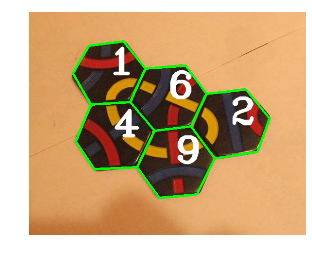

In [94]:
inn = item_path(img, contours2, item_contours, paths, ic_indices, db)

In [95]:
for i in inn:
    print i,

1 4 9 2 6


In [96]:
def build_item_graph(paths, ic_indices):
    fpaths = map(lambda x: paths[x], ic_indices)
    result = []
    for i in range(len(fpaths)):
        tmp = []
        for j in range(6):
            tmp.append(-1)
        result.append(tmp)
    for i in range(len(result)):
        old = fpaths[i][-1]
        for j in range(6):
            cur = fpaths[i][j]
            for k in range(len(result)):
                if i == k:
                    continue
                oldk = fpaths[k][-1]
                for l in range(6):
                    curk = fpaths[k][l]
                    if (curk == old) and (cur == oldk):
                        result[i][j] = k
                    oldk = curk
            old = cur
    return result

In [97]:
item_graph = build_item_graph(paths, ic_indices)

In [98]:
for i in item_graph:
    for j in i:
        print j,
    print

-1 1 4 -1 -1 -1
-1 -1 -1 2 4 0
-1 -1 -1 3 4 1
-1 -1 -1 -1 4 2
-1 -1 0 1 2 3


In [99]:
for i in db:
    for j in i[0]:
        print j,
    print

3 2 2 1 3 1
3 1 1 3 2 2
3 3 1 1 2 2
3 2 1 3 1 2
1 3 3 1 2 2
2 1 3 2 3 1
2 3 3 1 2 1
1 3 3 2 1 2
1 2 3 1 3 2
2 2 3 1 3 1


### Компиляция СИ-ПРОГРАММЫ

In [100]:
!cd ./c && ./compile.sh

### Запись входных данных

In [101]:
tmpfile = open('./c/tmpfile', 'w')

In [102]:
for i in db:
    for j in i[0]:
        tmpfile.write(str(j) + ' ')
    tmpfile.write('\n')

In [103]:
tmpfile.write(str(len(inn)) + '\n')

In [104]:
for i in inn:
    tmpfile.write(str(i) + ' ')
tmpfile.write('\n')

In [105]:
for i in item_graph:
    for j in i:
        tmpfile.write(str(j) + ' ')
    tmpfile.write('\n')

In [106]:
tmpfile.close()

### Запуск СИ-ПРОГРАММЫ

In [107]:
    !cd ./c && ./main <tmpfile >tmpfile_out

### Считывание выходных данных СИ-ПРОГРАММЫ

In [108]:
tmpfile = open('./c/tmpfile_out', 'r')

In [109]:
output = map(lambda x: int(x), tmpfile.readline()[:-2].split(' '))

In [110]:
print output

[1, 4, 9, 2, 6]


### Собираем всё в кучу

In [111]:
def detect_path(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    
    contours2 = get_contours(gs) #контур
    img2 = get_inside(img, contours2) # бинаризация
    
    selem = np.ones((9, 9))
    dilated = cv2.morphologyEx(img2, cv2.MORPH_CLOSE, selem)
    
    contours2 = get_contours(img2, False)
    img3 = draw_countors(img, contours2)
    
    contours2 = get_contours(dilated, False)
    img3 = draw_countors(img, contours2)
    
    ap = cv2.approxPolyDP(contours2[0], cv2.arcLength(contours2[0], True) / 100, True)
    img4 = draw_countors(img, ap)
    
    ap2 = map(lambda x: x[0], ap)
    
    result = []
    for i in range(len(ap2)):
        p1 = ap2[i]
        p2 = ap2[(i + 1) % len(ap2)]
        p3 = ap2[(i + 2) % len(ap2)]
        v1 = p1 - p2
        v2 = p3 - p2
        result.append(get_angle(v1, v2))
        
    ap3 = hagrid(ap2, points_to_contour(ap2))
    ap3 = hagrid(ap3, points_to_contour(ap2))
    img5 = draw_countors(img, points_to_contour(ap3))
    
    g = build_graph(ap3)
    
    paths = get_all_paths(g, ap3)
    
    item_contours = paths_to_contours(paths, ap3)
    ic_indices = range(len(paths))
    r = filter(lambda cnt: not is_hole(gs, cnt[0]), zip(item_contours, ic_indices))
    
    item_contours, ic_indices = zip(*r)
    
    inn = item_path(img, contours2, item_contours, paths, ic_indices, db)
    item_graph = build_item_graph(paths, ic_indices)
    
    tmpfile = open('./c/tmpfile', 'w')
    for i in db:
        for j in i[0]:
            tmpfile.write(str(j) + ' ')
        tmpfile.write('\n')
    tmpfile.write(str(len(inn)) + '\n')
    for i in inn:
        tmpfile.write(str(i) + ' ')
    tmpfile.write('\n')
    for i in item_graph:
        for j in i:
            tmpfile.write(str(j) + ' ')
        tmpfile.write('\n')
    tmpfile.close()
    
    !cd ./c && ./main <tmpfile >tmpfile_out
    
    tmpfile = open('./c/tmpfile_out', 'r')
    output = map(lambda x: int(x), tmpfile.readline()[:-2].split(' '))
    tmpfile.close()
    
    return output

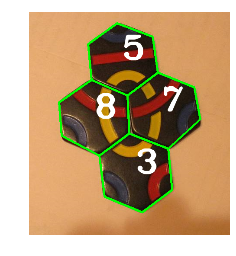

Path: 5 8 3 7


In [112]:
result = detect_path("./data/Path_4.bmp")
print "Path:",
for i in result:
    print i,

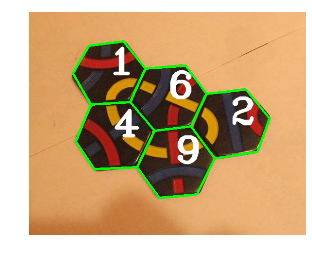

Path: 1 4 9 2 6


In [113]:
result = detect_path("./data/Path_5.bmp")
print "Path:",
for i in result:
    print i,

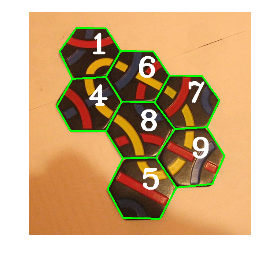

Path: 1 4 8 5 9 7 6


In [114]:
result = detect_path("./data/Path_7_1.bmp")
print "Path:",
for i in result:
    print i,

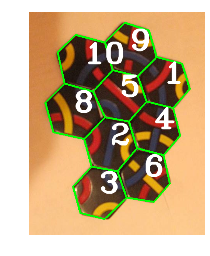

Path: 9 10 8 5 2 3 6 4 1


In [115]:
result = detect_path("./data/Path_9.bmp")
print "Path:",
for i in result:
    print i,

# Запуск тестов

## Количество фишек

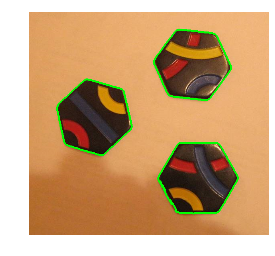

3 items


In [116]:
%matplotlib inline
print item_count("./data/Group_1.bmp"), 'items'

## Определение типов сегментов

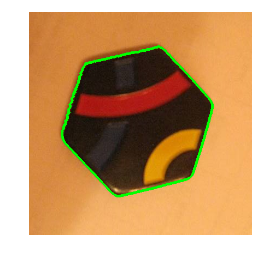

Red length = 2
Yellow length = 1
Blue length = 2


In [117]:
r_len, y_len, b_len = semgent_type("./data/Single_0.bmp")
print "Red length =", r_len 
print "Yellow length =", y_len
print "Blue length =", b_len

## Определение номеров фишек

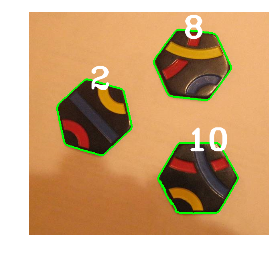

In [118]:
item_number("./data/Group_1.bmp", db)

## Нахождение пути

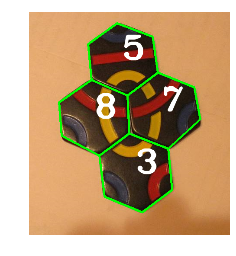

Path: 5 8 3 7


In [119]:
result = detect_path("./data/Path_4.bmp")
print "Path:",
for i in result:
    print i,